# Apply Parallelization to ML Algorithm with Exoplanet Data

In [1]:
# plots
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

import pandas as pd
import numpy as np
from collections import Counter

# ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, StandardScaler, normalize

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

# multi-processing
import multiprocessing as mp
from multiprocessing import Pool, Process

from dask.distributed import Client, progress
import dask_ml.datasets
import dask_ml.cluster
import joblib

# garbage collector
import gc

In [2]:
'''import torch.multiprocessing as mp_
mp = mp_.get_context('spawn')
import torch.nn as nn''';

In [3]:
exop = pd.read_csv('../Naive_Bayes_Tutorial/exoplanet_data_processed.csv')
exop

,mass,omega,tperi,tconj,tzero_tr,k,temp_calculated,temp_measured,geometric_albedo,log_g,...,mag_j,mag_h,mag_k,star_distance,star_metallicity,star_mass,star_radius,star_age,star_teff,label
0,5.704875,94.800000,2.452900e+06,2.452829e+06,2.466684e+06,302.800000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,110.600000,-0.35000,2.700000,19.000000,4.253231,4742.000000,non-habitable
1,5.704875,117.630000,2.452861e+06,2.452829e+06,2.466684e+06,189.700000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,119.500000,0.04000,1.800000,24.080000,1.560000,4340.000000,non-habitable
2,5.704875,168.622899,2.452861e+06,2.452829e+06,2.466684e+06,100.000000,1006.863821,1588.525,0.236867,4.255023,...,3.02000,2.610000,2.330000,76.400000,-0.24000,2.200000,11.000000,4.253231,4813.000000,non-habitable
3,9.653000,22.780000,2.451373e+06,2.452829e+06,2.466684e+06,90.000000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable
4,6.900000,15.200000,9.100000e+03,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,0.620000,44.519000,2.450034e+06,2.452829e+06,2.466684e+06,70.519000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable
5249,9.100000,247.629000,2.449923e+06,2.452829e+06,2.466684e+06,53.498000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable
5250,23.580000,252.991000,2.450059e+06,2.452829e+06,2.466684e+06,67.700000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,habitable
5251,5.704875,7.300000,2.124186e+06,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable


In [4]:
Counter(exop['label'])

Counter({'non-habitable': 5026, 'habitable': 227})

## Prep data

In [5]:
lb = LabelBinarizer()
exop['label_bin'] = lb.fit_transform(exop['label'])
exop

,mass,omega,tperi,tconj,tzero_tr,k,temp_calculated,temp_measured,geometric_albedo,log_g,...,mag_h,mag_k,star_distance,star_metallicity,star_mass,star_radius,star_age,star_teff,label,label_bin
0,5.704875,94.800000,2.452900e+06,2.452829e+06,2.466684e+06,302.800000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,110.600000,-0.35000,2.700000,19.000000,4.253231,4742.000000,non-habitable,1
1,5.704875,117.630000,2.452861e+06,2.452829e+06,2.466684e+06,189.700000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,119.500000,0.04000,1.800000,24.080000,1.560000,4340.000000,non-habitable,1
2,5.704875,168.622899,2.452861e+06,2.452829e+06,2.466684e+06,100.000000,1006.863821,1588.525,0.236867,4.255023,...,2.610000,2.330000,76.400000,-0.24000,2.200000,11.000000,4.253231,4813.000000,non-habitable,1
3,9.653000,22.780000,2.451373e+06,2.452829e+06,2.466684e+06,90.000000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable,1
4,6.900000,15.200000,9.100000e+03,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,0.620000,44.519000,2.450034e+06,2.452829e+06,2.466684e+06,70.519000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable,1
5249,9.100000,247.629000,2.449923e+06,2.452829e+06,2.466684e+06,53.498000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable,1
5250,23.580000,252.991000,2.450059e+06,2.452829e+06,2.466684e+06,67.700000,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,habitable,0
5251,5.704875,7.300000,2.124186e+06,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable,1


In [6]:
x = exop.drop(['label', 'label_bin'], axis=1)
y = exop['label_bin']

In [7]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)

In [8]:
smote = SMOTE()
smote_train_x, smote_train_y = smote.fit_resample(train_x, train_y)
smote_train_y = smote_train_y.astype('int')

In [9]:
x_train_norm = normalize(X=smote_train_x)
x_test_norm = normalize(X=test_x)

In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_norm)
x_test = scaler.fit_transform(x_test_norm)

## Grid Search

In [11]:
RanFor = RandomForestClassifier(random_state=42)

In [12]:
param_grid = {'n_estimators': [200, 500],
              'max_features': ['sqrt', 'log2'], 
              'max_depth' : [3, 5, 8],
              'criterion' :['gini', 'entropy']
              }

### Regular

In [14]:
grid_search_ = GridSearchCV(estimator=RanFor, param_grid=param_grid, cv=5)

In [15]:
grid_search_.fit(x_train, smote_train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [17]:
results_reg = grid_search_.best_params_
results_reg

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [19]:
with open('best_params_regular.txt', 'w') as f:
    print(results_reg, file=f)

### Parallelized

In [13]:
grid_search = GridSearchCV(estimator=RanFor, param_grid=param_grid, cv=5, verbose=2)

In [14]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4, n_workers=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.26.36.79:8787/status,
Dashboard: http://10.26.36.79:8787/status,Workers: 2
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: False
Comm: inproc://10.26.36.79/45003/1,Workers: 2
Dashboard: http://10.26.36.79:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: inproc://10.26.36.79/45003/4,Total threads: 4
Dashboard: http://10.26.36.79:56250/status,Memory: 8.00 GiB
Nanny: None,


In [15]:
gc.disable()

In [16]:
with joblib.parallel_backend('dask'):
    grid_search.fit(x_train, smote_train_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=  21.2s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=  23.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=  26.9s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=  27.1s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=  26.7s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=  27.7s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=  28.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=  28.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=  27.9s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=  28.4

In [17]:
gc.enable()

In [18]:
results_dask = grid_search.best_params_
results_dask

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [19]:
with open('best_params_dask.txt', 'w') as f:
    print(results_dask, file=f)

## Random Forest with Best Hyper-parameters

In [20]:
forest = RandomForestClassifier(n_estimators=200, 
                                max_features='sqrt', 
                                max_depth=8, 
                                criterion='entropy', 
                                random_state=42)

In [26]:
forest.fit(x_train, smote_train_y)
y_pred = forest.predict(x_test)

In [27]:
print('Validation Accuracy', accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

Validation Accuracy 0.5086505190311419
              precision    recall  f1-score   support

           0       0.03      0.35      0.05        66
           1       0.95      0.51      0.67      1668

    accuracy                           0.51      1734
   macro avg       0.49      0.43      0.36      1734
weighted avg       0.92      0.51      0.64      1734



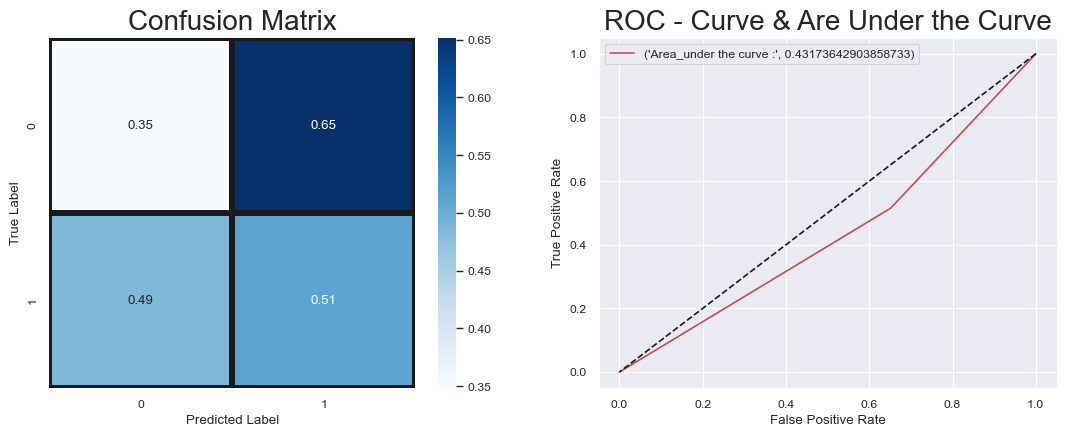

In [28]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y, y_pred, normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve and Area under the curve plotting
predicting_prob_adasyn = forest.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
plt.subplot(222)
plt.plot(fpr, tpr, label = ("Area_under the curve :", auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - Curve & Are Under the Curve", fontsize=20);